In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import matplotlib.pyplot as plt
import os
from datetime import datetime
import random
import string

seed = 161
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
env.seed(seed);

N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

def discretize(c_pos_val, c_vel_val, p_ang_val, p_vel_val, c_pos_s, c_vel_s, p_ang_s, p_vel_s):
    c_pos_indx = np.where(c_pos_s >= c_pos_val)[0][0].astype(int)
    c_vel_indx = np.where(c_vel_s >= c_vel_val)[0][0].astype(int)
    p_ang_indx = np.where(p_ang_s >= p_ang_val)[0][0].astype(int)
    p_vel_indx = np.where(p_vel_s >= p_vel_val)[0][0].astype(int)
    return [c_pos_indx, c_vel_indx, p_ang_indx, p_vel_indx]

In [2]:
QUANTIZATION_LEVEL = 40
print("Quantization Level: ", QUANTIZATION_LEVEL)

Quantization Level:  40


In [3]:
Q_TABLE = np.zeros((QUANTIZATION_LEVEL,
                    QUANTIZATION_LEVEL,
                    QUANTIZATION_LEVEL,
                    QUANTIZATION_LEVEL, 
                    N_ACTIONS))

D_Q_TABLE = Q_TABLE

c_pos_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)
c_vel_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)
p_ang_s = np.linspace(-1, 1, QUANTIZATION_LEVEL)
p_vel_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)

In [4]:
T_LR           = 1e-1
T_GAMMA        = 0.9
T_EPSILON      = 0.9

NO_OF_NODES    = 50
NO_OF_EPISODES = 50
TIMESTEP_LIMIT = 200

In [5]:
# Hyper Parameters
BATCH_SIZE          = 32
LR                  = 1e-3  # learning rate
EPSILON             = 0.9   # greedy policy
GAMMA               = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
SEGREGATION_BIAS    = 6     # no. of non-terminal memories in batch

In [6]:
NO_OF_ITERATIONS = 10
NN_ITERATIONS    = 20000

In [7]:
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [8]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 50)
        nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
        self.out = nn.Linear(50, N_ACTIONS)
        nn.init.xavier_uniform_(self.out.weight)   # initialization

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        actions_value = self.out(x)
        return actions_value
    
class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
#         print("Neural net")
#         print(self.eval_net)

        self.learn_step_counter  = 0 # for target updating
        
        self.good_memory_counter = 0 # for storing non-terminal memories
        self.good_memory         = []#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.bad_memory_counter  = 0 # for storing terminal memories
        self.bad_memory          = []#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy()
        return actions_value
    
#     def store_transition(self, s, a, r, s_):
#         transition = np.hstack((s, [a, r], s_))
#         if r > 0: #non-terminal rewards
#             # replace the old memory with new memory
#             index = self.good_memory_counter % int(MEMORY_CAPACITY/2)
#             self.good_memory[index, :] = transition
#             self.good_memory_counter += 1
        
#         else: #terminal rewards
#             # replace the old memory with new memory
#             index = self.bad_memory_counter % int(MEMORY_CAPACITY/2)
#             self.bad_memory[index, :] = transition
#             self.bad_memory_counter += 1

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        good_sample_index = np.random.choice(int(self.good_memory.shape[0]), int(SEGREGATION_BIAS))
        bad_sample_index  = np.random.choice(int(self.bad_memory.shape[0]), int(BATCH_SIZE-SEGREGATION_BIAS))

        b_good_memory = self.good_memory[good_sample_index, :]
        b_bad_memory  = self.bad_memory[bad_sample_index, :]
        b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [9]:
dqn = DQN()

In [10]:
RFILE = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8))+'lo_seg'
print("SCRATCH FILE = ", RFILE)

SCRATCH FILE =  STI6WR1Zlo_seg




ITERATION # 0
TIME TO GATHER 2500 experiences:0:03:31.978909


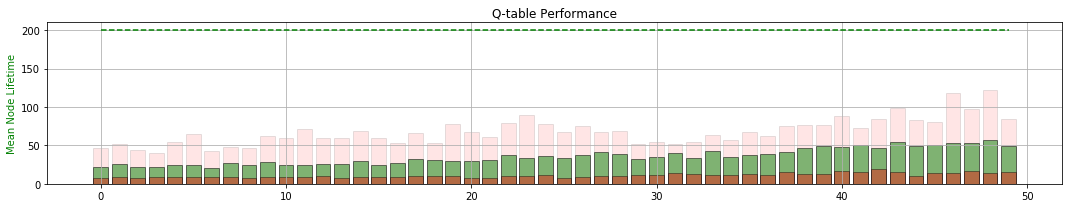

Training Neural Network for  20000 iterations
Validating	MEAN TIME:  9.415
Validating	MEAN TIME:  9.435
Validating	MEAN TIME:  9.34
Validating	MEAN TIME:  9.405
Validating	MEAN TIME:  9.355
TRAINING TIME:0:00:18.379819


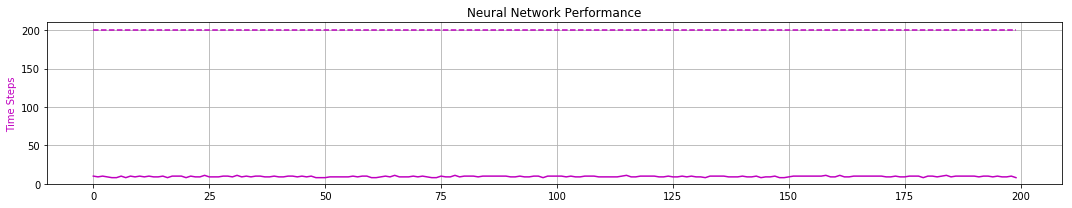

Discretizing Q-Value Function
DISCRETIZATION TIME:0:02:56.202905
Q-Table Updated


ITERATION # 1
TIME TO GATHER 2500 experiences:0:00:04.832248


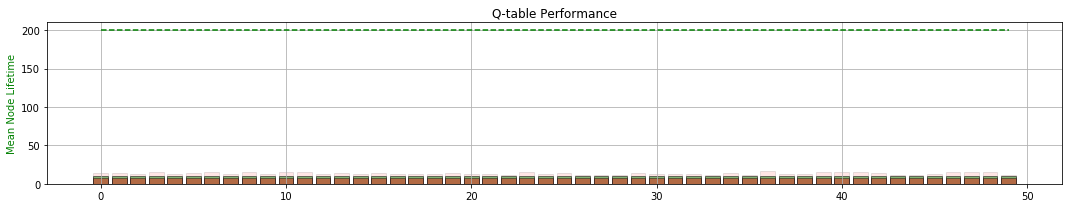

Training Neural Network for  20000 iterations
Validating	MEAN TIME:  9.5
Validating	MEAN TIME:  114.57
Validating	MEAN TIME:  145.515
Validating	MEAN TIME:  119.12
Validating	MEAN TIME:  112.58
TRAINING TIME:0:00:36.318046


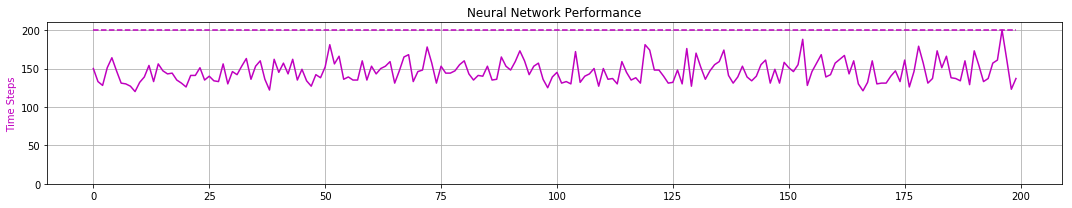

Discretizing Q-Value Function
DISCRETIZATION TIME:0:03:14.826088
Q-Table Updated


ITERATION # 2
TIME TO GATHER 2500 experiences:0:00:45.568428


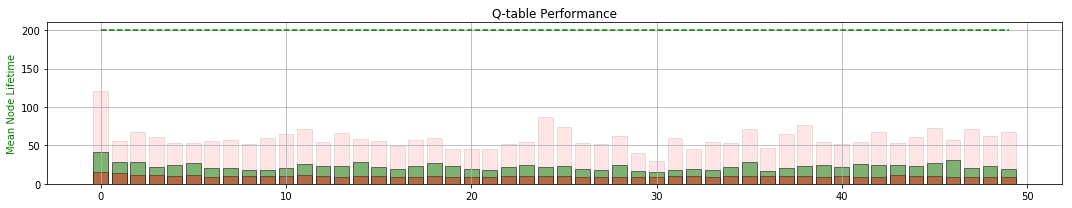

Training Neural Network for  20000 iterations
Validating	MEAN TIME:  9.385
Validating	MEAN TIME:  9.375
Validating	MEAN TIME:  9.39
Validating	MEAN TIME:  16.12
Validating	MEAN TIME:  42.705
TRAINING TIME:0:00:22.795006


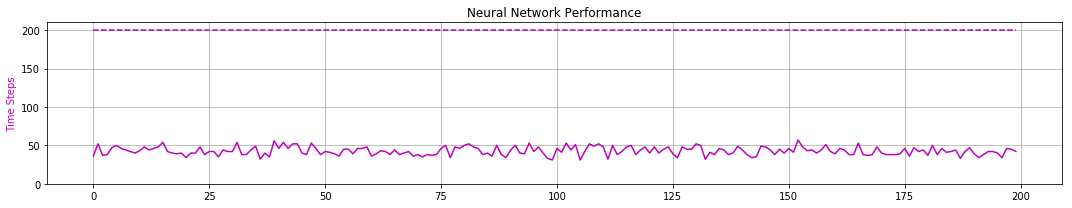

Discretizing Q-Value Function
DISCRETIZATION TIME:0:03:03.538044
Q-Table Updated


ITERATION # 3
TIME TO GATHER 2500 experiences:0:00:18.298990


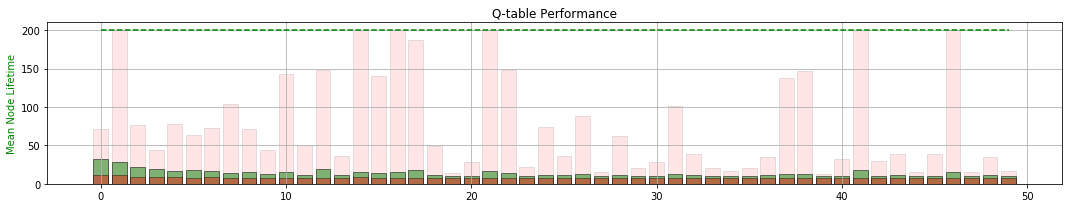

Training Neural Network for  20000 iterations
Validating	MEAN TIME:  179.295
Validating	MEAN TIME:  146.085
Validating	MEAN TIME:  187.39
Validating	MEAN TIME:  199.67
Validating	MEAN TIME:  104.695
TRAINING TIME:0:00:39.111366


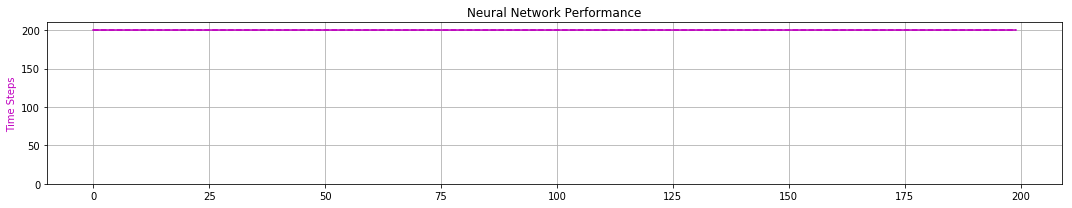

Discretizing Q-Value Function
DISCRETIZATION TIME:0:03:07.804574
Q-Table Updated


ITERATION # 4
TIME TO GATHER 2500 experiences:1:18:33.861751


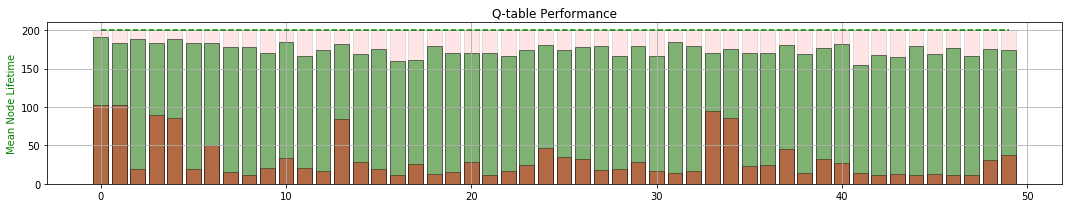

Training Neural Network for  20000 iterations
Validating	MEAN TIME:  200.0
Validating	MEAN TIME:  200.0
Validating	MEAN TIME:  200.0
Validating	MEAN TIME:  200.0
Validating	MEAN TIME:  200.0
TRAINING TIME:0:00:41.996826


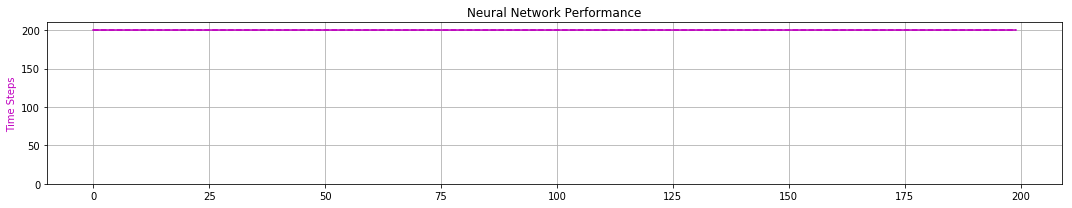

Discretizing Q-Value Function
DISCRETIZATION TIME:0:02:49.697523
Q-Table Updated


ITERATION # 5
TIME TO GATHER 2500 experiences:0:50:38.963845


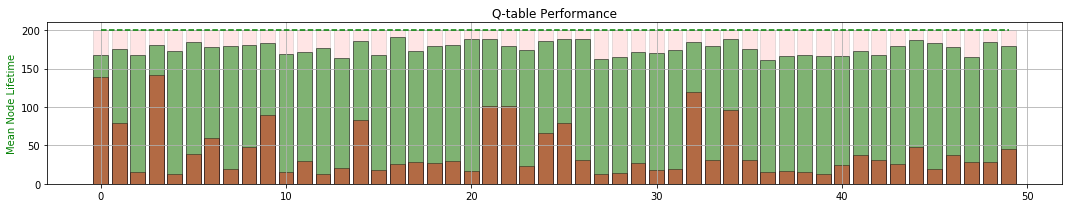

Training Neural Network for  20000 iterations
Validating	MEAN TIME:  200.0
Validating	MEAN TIME:  200.0
Validating	MEAN TIME:  200.0
Validating	MEAN TIME:  200.0
Validating	MEAN TIME:  200.0
TRAINING TIME:0:00:32.513329


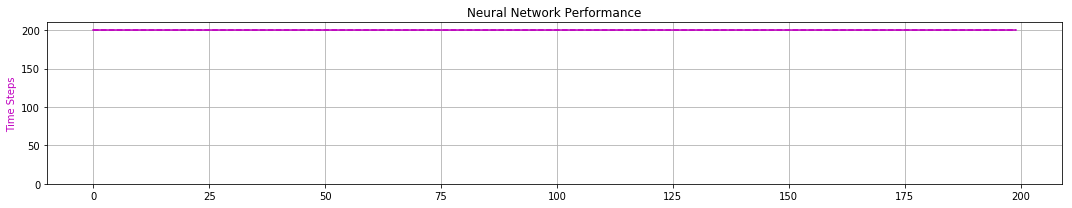

Discretizing Q-Value Function
DISCRETIZATION TIME:0:02:20.302769
Q-Table Updated


ITERATION # 6


In [ ]:
for iteration in range(NO_OF_ITERATIONS):
    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    node_time_rec = np.zeros((NO_OF_NODES, NO_OF_EPISODES))
    exp_rec = np.empty(N_STATES * 2 + 2) # will contain experiences of all nodes for all episodes

    for i_node in range(NO_OF_NODES):
        time_rec = []
        level_up_flag    = False
        level_up_counter = 0
        level_up_metric  = 195
        for i_episode in range(NO_OF_EPISODES):
            time_steps = 0
            s = env.reset()
            while True:
        #         env.render()
                [c_pos_state, 
                c_vel_state, 
                p_ang_state, 
                p_vel_state] = discretize(s[0],s[1],s[2],s[3],
                                         c_pos_s, 
                                         c_vel_s, 
                                         p_ang_s, 
                                         p_vel_s)
                time_steps += 1
                if np.random.uniform() > T_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = Q_TABLE[c_pos_state, c_vel_state, p_ang_state, p_vel_state, :].argmax()

                 # take action
                s_, r, done, info = env.step(a)

                if done:
                    r = -1
                    if time_steps >= TIMESTEP_LIMIT:
                        r = 1

                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                [next_c_pos_state, 
                next_c_vel_state, 
                next_p_ang_state, 
                next_p_vel_state] = discretize(s_[0],    s_[1],    s_[2],    s_[3],
                                              c_pos_s,  c_vel_s,  p_ang_s,  p_vel_s)

                # learn
                this_state = tuple([c_pos_state, 
                              c_vel_state, 
                              p_ang_state, 
                              p_vel_state])

                next_state = tuple([ next_c_pos_state, 
                               next_c_vel_state, 
                               next_p_ang_state, 
                               next_p_vel_state])

                Q_TABLE[this_state][a] = Q_TABLE[this_state][a] + T_LR * (r + T_GAMMA * Q_TABLE[next_state].max() - 
                                                                         Q_TABLE[this_state][a])
                if done:
                    node_time_rec[i_node][i_episode] = time_steps
                    break
                s = s_
            if np.mean(node_time_rec[i_node][-10:]) > level_up_metric:
                level_up_metric_counter += 1
            else:
                level_up_metric_counter = 0

            if level_up_metric_counter > 10:
                level_up_metric_counter = 0
                T_LR *= 0.1
                if T_EPSILON < 0.99:
                    T_EPSILON += 0.01  

    print("TIME TO GATHER {:d} experiences:{}".format(NO_OF_NODES*NO_OF_EPISODES, (datetime.now()-tic)))
    exp_rec = np.delete(exp_rec, 0, 0)
    #PLOT EXPERIENCES
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()

    #GATHER ALL EXPERIENCES
    all_exp = exp_rec

    #shuffle experiences
    np.random.shuffle(all_exp)

    #segregate experiences
    dqn.good_memory = all_exp[all_exp[:,5] == 1]
    dqn.bad_memory = all_exp[all_exp[:,5] < 1]

    #learn
    print("Training Neural Network for ", NN_ITERATIONS, "iterations")
    tic=datetime.now()
    level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("Validating", end='\t')
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = env.reset()
                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = env.step(a)
                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= level_up_metric:
                level_up_metric = mean_time
                torch.save(dqn.eval_net.state_dict(), RFILE +'_'+str(QUANTIZATION_LEVEL))

    print("TRAINING TIME:{}".format(datetime.now()-tic))


    dqn.eval_net.load_state_dict(torch.load(RFILE +'_'+str(QUANTIZATION_LEVEL)))
    dqn.eval_net.eval()
    
    #test NN policy
    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()
        while True:
    #         env.render()
            time_step += 1 
            a = dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()


    # Discretize the Q-Value Functions
    print("Discretizing Q-Value Function")
    tic=datetime.now()
    c_pos_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)
    c_vel_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)
    p_ang_s = np.linspace(-1, 1, QUANTIZATION_LEVEL)
    p_vel_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)


    for c_pos_indx in np.arange(0,c_pos_s.size):
        for c_vel_indx in np.arange(0,c_vel_s.size):
            for p_ang_indx in np.arange(0,p_ang_s.size):
                for p_vel_indx in np.arange(0,p_vel_s.size):

                        state = [c_pos_s[c_pos_indx],
                                 c_vel_s[c_vel_indx],
                                 p_ang_s[p_ang_indx],
                                 p_vel_s[p_vel_indx]]

                        D_Q_TABLE[c_pos_indx,
                                c_vel_indx,
                                p_ang_indx,
                                p_vel_indx, :] = dqn.get_qvals(state)
    print("DISCRETIZATION TIME:{}".format(datetime.now()-tic))
    Q_TABLE = D_Q_TABLE.copy()
#     #stretch both Q_TABLE and D_Q_TABLE to [-1,1]
#     pos = D_Q_TABLE/D_Q_TABLE.max()
#     pos[pos<0] = 0
#     neg = D_Q_TABLE/np.abs(D_Q_TABLE.min())
#     neg[neg>0] = 0
#     D_Q_TABLE = pos + neg
    
#     pos = Q_TABLE/Q_TABLE.max()
#     pos[pos<0] = 0
#     neg = Q_TABLE/np.abs(Q_TABLE.min())
#     neg[neg>0] = 0
#     Q_TABLE = pos + neg
      
    #NORMALIZE Q-TABLE AND UPDATE
#     Q_TABLE   = Q_TABLE + 0.7*(D_Q_TABLE-Q_TABLE)

    print("Q-Table Updated")